***Лабораторная работа №3 "Написание LSTM модели". Коршунов Егор Станиславович БВТ2202***

**Цель:**
1. Написать LSTM модель, способную классифицировать текст на токсичный или не токсичный. 
2. В качестве токенизатора можно использовать любой токенизатор с hf либо написать свой эмбеддинг слой.
3. Использование в качестве лосса BCE. 
4. Использование в качестве оптимизатор Adam/AdamW, lr=3e-4. 
5. Рассчитать такие метрики, как: accuracy, f1, roc-auc, pr-auc.



In [ ]:
# Импорт библиотек
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, average_precision_score)
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# 1. Загрузка и анализ данных
def load_and_analyze_data():
    try:
        df = pd.read_csv('labeled.csv', sep=',')
        print(f"Data shape: {df.shape}")
        
        # Анализ распределения классов
        print("\nClass distribution:")
        print(df['toxic'].value_counts(normalize=True))
        
        # Анализ длины текстов
        df['text_length'] = df['comment'].apply(lambda x: len(x.split()))
        print("\nText length statistics:")
        print(df['text_length'].describe())
        
        # Визуализация распределения длин
        plt.hist(df['text_length'], bins=50)
        plt.title('Text Length Distribution')
        plt.xlabel('Text Length (words)')
        plt.ylabel('Frequency')
        plt.show()
        
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

Подготовка данных и создание DataLoader

In [3]:
# 2. Подготовка данных
def prepare_data(df, test_size=0.2, val_size=0.25):
    try:
        train_df, test_df = train_test_split(
            df, test_size=test_size, random_state=42, stratify=df['toxic'])
        train_df, val_df = train_test_split(
            train_df, test_size=val_size, random_state=42, stratify=train_df['toxic'])
        
        print(f"\nTrain size: {len(train_df)}")
        print(f"Val size: {len(val_df)}")
        print(f"Test size: {len(test_df)}")
        
        return train_df, val_df, test_df
    except Exception as e:
        print(f"Error preparing data: {e}")
        raise

# 3. Создание Dataset и DataLoader
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        try:
            text = str(self.texts[idx])
            label = self.labels[idx]
            
            encoding = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt',
            )
            
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.float)
            }
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
            raise

def create_data_loaders(train_df, val_df, test_df, tokenizer, max_len, batch_size):
    try:
        num_workers = 0 if os.name == 'nt' else 2
        
        train_loader = DataLoader(
            ToxicCommentsDataset(train_df['comment'].to_numpy(), train_df['toxic'].to_numpy(), tokenizer, max_len),
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers
        )
        
        val_loader = DataLoader(
            ToxicCommentsDataset(val_df['comment'].to_numpy(), val_df['toxic'].to_numpy(), tokenizer, max_len),
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers
        )
        
        test_loader = DataLoader(
            ToxicCommentsDataset(test_df['comment'].to_numpy(), test_df['toxic'].to_numpy(), tokenizer, max_len),
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers
        )
        
        return train_loader, val_loader, test_loader
    except Exception as e:
        print(f"Error creating DataLoaders: {e}")
        raise

Модель LSTM

In [4]:
# 4. Определение модели
class ToxicLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, input_ids, attention_mask=None):
        embedded = self.embedding(input_ids)
        
        if attention_mask is not None:
            lengths = attention_mask.sum(dim=1).cpu()
            packed_embedded = nn.utils.rnn.pack_padded_sequence(
                embedded, lengths, batch_first=True, enforce_sorted=False)
            packed_output, (hidden, cell) = self.lstm(packed_embedded)
            output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        else:
            output, (hidden, cell) = self.lstm(embedded)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

def init_weights(m):
    if isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight)
        if m.padding_idx is not None:
            m.weight.data[m.padding_idx].zero_()
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0.0)

Обучение и оценка

In [ ]:
# 5. Функции обучения и оценки

def train_epoch(model, data_loader, criterion, optimizer, device, scheduler=None):
    """Выполняет одну эпоху обучения модели.
    
    Args:
        model: Модель для обучения
        data_loader: DataLoader с обучающими данными
        criterion: Функция потерь (BCEWithLogitsLoss)
        optimizer: Оптимизатор (AdamW)
        device: Устройство для вычислений (cpu/cuda)
        scheduler: Планировщик learning rate (опционально)
    
    Returns:
        accuracy: Точность на эпохе
        loss: Среднее значение потерь на эпохе
    """
    # Переводим модель в режим обучения (включает dropout и др.)
    model.train()
    losses = []
    correct_predictions = 0  # Счетчик правильных предсказаний
    
    # Итерация по батчам с прогресс-баром
    for d in tqdm(data_loader, desc="Training"):
        try:
            # Перенос данных на выбранное устройство
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['label'].to(device)
            
            # Обнуляем градиенты с предыдущей итерации
            optimizer.zero_grad()
            
            # Прямой проход (forward pass)
            outputs = model(input_ids, attention_mask)
            # Получаем предсказания (0 или 1) через сигмоиду с порогом 0.5
            preds = (torch.sigmoid(outputs) > 0.5).float()
            # Вычисляем потери
            loss = criterion(outputs, labels.unsqueeze(1))
            
            # Обновляем счетчики
            correct_predictions += torch.sum(preds == labels.unsqueeze(1))
            losses.append(loss.item())
            
            # Обратный проход (backward pass)
            loss.backward()
            # Обрезаем градиенты для предотвращения "взрыва"
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            if grad_norm > 1.0:
                print(f"Clipped gradients (norm was {grad_norm:.2f})")
            # Шаг оптимизации
            optimizer.step()
            
            # Обновление learning rate (если scheduler указан)
            if scheduler:
                scheduler.step()
        except Exception as e:
            print(f"Error during training batch: {e}")
            raise
    
    # Вычисляем точность и средние потери для эпохи
    accuracy = (correct_predictions.double() / len(data_loader.dataset)).item()
    loss = np.mean(losses)
    
    return accuracy, loss


def eval_model(model, data_loader, criterion, device):
    """Оценивает модель на валидационном/тестовом наборе данных.
    
    Args:
        model: Модель для оценки
        data_loader: DataLoader с данными для оценки
        criterion: Функция потерь
        device: Устройство для вычислений
    
    Returns:
        accuracy: Точность предсказаний
        loss: Среднее значение потерь
        f1: F1-score
        roc_auc: ROC-AUC score
        pr_auc: PR-AUC score
    """
    # Переводим модель в режим оценки (отключает dropout и др.)
    model.eval()
    losses = []
    correct_predictions = 0
    all_probs = []  # Сохраняем все вероятности для метрик
    all_labels = []  # Сохраняем все истинные метки
    
    # Отключаем вычисление градиентов для ускорения
    with torch.no_grad():
        for d in tqdm(data_loader, desc="Evaluating"):
            try:
                # Перенос данных на устройство
                input_ids = d['input_ids'].to(device)
                attention_mask = d['attention_mask'].to(device)
                labels = d['label'].to(device)
                
                # Прямой проход
                outputs = model(input_ids, attention_mask)
                # Вероятности положительного класса
                probs = torch.sigmoid(outputs)
                # Бинарные предсказания
                preds = (probs > 0.5).float()
                
                # Вычисление потерь
                loss = criterion(outputs, labels.unsqueeze(1))
                # Обновление счетчиков
                correct_predictions += torch.sum(preds == labels.unsqueeze(1))
                losses.append(loss.item())
                
                # Сохраняем вероятности и метки для метрик
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            except Exception as e:
                print(f"Error during evaluation batch: {e}")
                raise
    
    # Преобразуем в numpy массивы
    all_probs = np.array(all_probs).flatten()
    all_labels = np.array(all_labels)
    
    # Вычисляем метрики
    accuracy = correct_predictions.double() / len(data_loader.dataset)
    loss = np.mean(losses)
    f1 = f1_score(all_labels, all_probs > 0.5)  # F1 для порога 0.5
    roc_auc = roc_auc_score(all_labels, all_probs)  # ROC-AUC
    pr_auc = average_precision_score(all_labels, all_probs)  # PR-AUC
    
    return accuracy, loss, f1, roc_auc, pr_auc

Раскчет KL дивергенции

In [6]:
# 6. Расчет KL дивергенции
def calculate_kl_divergence(model, data_loader, device):
    """Вычисляет KL-дивергенцию между эмпирическим распределением меток 
    и распределением предсказаний модели.
    
    KL-дивергенция измеряет, насколько одно распределение отличается от другого.
    В данном случае показывает, насколько предсказания модели отличаются от истинных меток.
    
    Args:
        model: Обученная модель для оценки
        data_loader: DataLoader с данными для оценки
        device: Устройство для вычислений (cpu/cuda)
    
    Returns:
        kl: Значение KL-дивергенции (несимметричная мера различия распределений)
    """
    
    # Переводим модель в режим оценки (отключаем dropout и т.д.)
    model.eval()
    all_probs = []  # Здесь будут храниться все предсказанные вероятности
    all_labels = []  # Здесь будут храниться все истинные метки
    
    # Отключаем вычисление градиентов для ускорения и экономии памяти
    with torch.no_grad():
        # Итерируемся по батчам данных с прогресс-баром
        for d in tqdm(data_loader, desc="Calculating KL"):
            # Переносим данные на нужное устройство (GPU/CPU)
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['label'].to(device)
            
            # Получаем предсказания модели
            outputs = model(input_ids, attention_mask)
            # Применяем сигмоиду для получения вероятностей
            probs = torch.sigmoid(outputs)
            
            # Сохраняем вероятности и метки (переводим на CPU для numpy)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Преобразуем списки в numpy массивы и делаем их одномерными
    all_probs = np.array(all_probs).flatten()
    all_labels = np.array(all_labels)
    
    # Рассчитываем гистограммы для двух распределений:
    # p - эмпирическое распределение истинных меток
    # q - распределение предсказанных вероятностей модели
    # Используем 2 бина (0 и 1) в диапазоне [0, 1]
    p = np.histogram(all_labels, bins=2, range=(0,1), density=True)[0]
    q = np.histogram(all_probs, bins=2, range=(0,1), density=True)[0]
    
    # Добавляем небольшое значение для избежания деления на 0 и логарифма от 0
    p = np.clip(p, 1e-10, 1)  # Ограничиваем снизу 1e-10
    q = np.clip(q, 1e-10, 1)  # Ограничиваем снизу 1e-10
    
    # Вычисляем KL-дивергенцию: KL(P||Q) = sum(p * log(p/q))
    # Это forward KL, которую минимизирует MLE (maximum likelihood estimation)
    kl = np.sum(p * np.log(p / q))
    
    return kl

Основной цикл

Начало обучения...
Data shape: (14412, 2)

Class distribution:
toxic
0.0    0.66514
1.0    0.33486
Name: proportion, dtype: float64

Text length statistics:
count    14412.000000
mean        27.946017
std         41.432218
min          1.000000
25%          9.000000
50%         16.000000
75%         32.000000
max       1078.000000
Name: text_length, dtype: float64


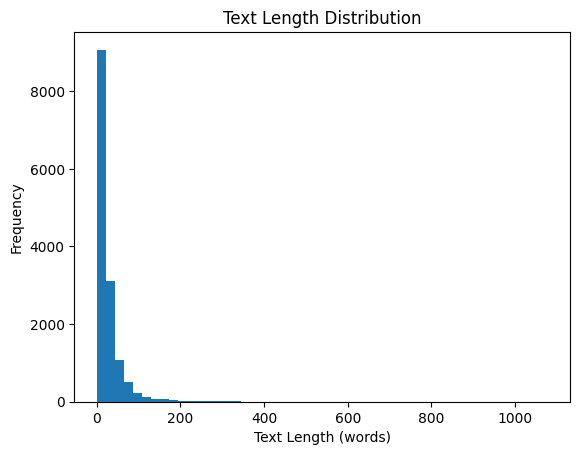


Выбранный MAX_LEN: 84

Train size: 8646
Val size: 2883
Test size: 2883

Sample text: Грамматикуса вспомнил. Один в один прямо)
Обозначенный: ['граммати', '##куса', 'вспомнил', '.', 'один', 'в', 'один', 'прямо', ')'] ...

Пакетная проверка:
Форма входных идентификаторов: torch.Size([32, 84])
Форма маски внимания: torch.Size([32, 84])
Форма лейблов: torch.Size([32])
Пример лейбла: 0.0

Using device: cpu
CUDA available: False

Модельный тест forward пройден успешно!
Форма выходного сигнала: torch.Size([32, 1])

Epoch 1/5
----------
Batch 271/271 | Loss: 0.5221 | Acc: 0.7989

Evaluating: 100%|██████████| 91/91 [00:04<00:00, 18.86it/s]



Train Loss: 0.5221 | Acc: 0.7989
Val Loss: 0.3366 | Acc: 0.8932
F1: 0.8404 | ROC-AUC: 0.9493 | PR-AUC: 0.9042
Модель сохранена!

Epoch 2/5
----------
Batch 271/271 | Loss: 0.1512 | Acc: 0.9557

Evaluating: 100%|██████████| 91/91 [00:04<00:00, 18.47it/s]



Train Loss: 0.1512 | Acc: 0.9557
Val Loss: 0.3847 | Acc: 0.8633
F1: 0.8148 | ROC-AUC: 0.9435 | PR-AUC: 0.8994

Epoch 3/5
----------
Batch 271/271 | Loss: 0.0458 | Acc: 0.9905

Evaluating: 100%|██████████| 91/91 [00:04<00:00, 18.37it/s]
C:\Users\Violetta\AppData\Local\Temp\ipykernel_8992\2743171696.py:202: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature

Сработала ранняя остановка!


Evaluating: 100%|██████████| 91/91 [00:04<00:00, 18.63it/s]



Результаты теста:
Точность: 0.8928
F1: 0.8406
ROC-AUC: 0.9487
PR-AUC: 0.8989


Calculating KL: 100%|██████████| 91/91 [00:04<00:00, 19.10it/s]



KL Divergence: -0.0062


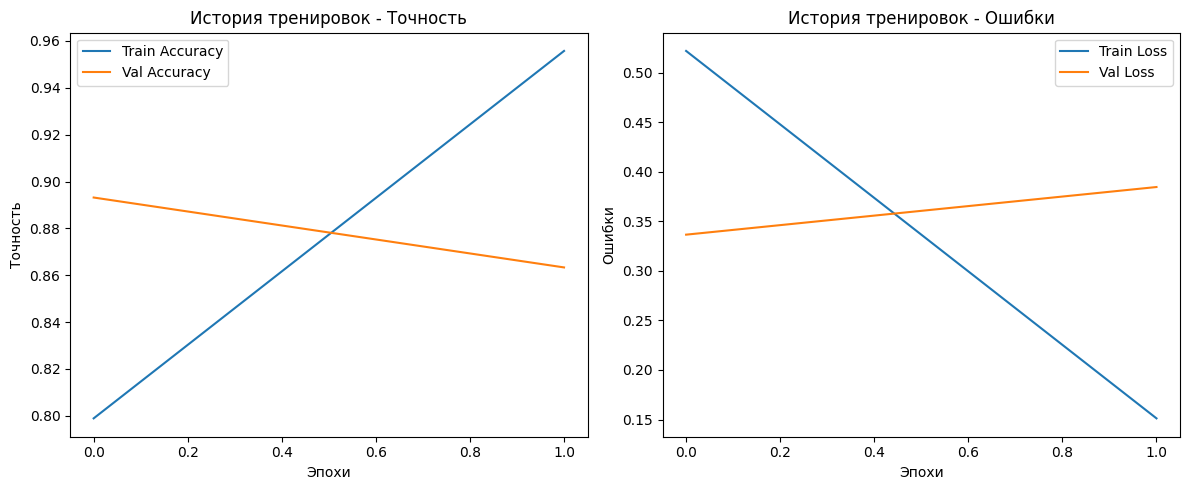


Обучение успешно завершено!
Final Train Accuracy: 0.9557
Final Val Accuracy: 0.8633


In [9]:
# 7. Метрики и вспомогательные функции
def binary_accuracy(preds, y):
    """
    Возвращает точность для бинарной классификации
    """
    # Округление предсказаний до 0 или 1
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()  # преобразуем в float для деления
    acc = correct.sum() / len(correct)
    return acc

# 8. Основной цикл обучения
def train_model():
    try:
        # Загрузка и анализ данных
        df = load_and_analyze_data()
        
        # Определение максимальной длины последовательности
        max_len = int(df['text_length'].quantile(0.95))
        print(f"\nВыбранный MAX_LEN: {max_len}")
        
        # Подготовка данных
        train_df, val_df, test_df = prepare_data(df)
        
        # Инициализация токенизатора
        tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
        vocab_size = tokenizer.vocab_size
        pad_idx = tokenizer.pad_token_id
        
        # Проверка токенизации
        sample_text = train_df.iloc[0]['comment']
        print("\nSample text:", sample_text)
        print("Обозначенный:", tokenizer.tokenize(sample_text)[:20], "...")
        
        # Создание DataLoader
        batch_size = 32
        train_loader, val_loader, test_loader = create_data_loaders(
            train_df, val_df, test_df, tokenizer, max_len, batch_size)
        
        # Проверка батча
        test_batch = next(iter(train_loader))
        print("\nПакетная проверка:")
        print("Форма входных идентификаторов:", test_batch['input_ids'].shape)
        print("Форма маски внимания:", test_batch['attention_mask'].shape)
        print("Форма лейблов:", test_batch['label'].shape)
        print("Пример лейбла:", test_batch['label'][0].item())
        
        # Определение устройства
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"\nUsing device: {device}")
        print(f"CUDA available: {torch.cuda.is_available()}")
        if torch.cuda.is_available():
            print(f"GPU: {torch.cuda.get_device_name(0)}")
        
        # Параметры модели
        embedding_dim = 256
        hidden_dim = 128
        output_dim = 1
        n_layers = 2
        dropout = 0.5
        
        # Инициализация модели
        model = ToxicLSTM(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            n_layers=n_layers,
            dropout=dropout,
            pad_idx=pad_idx
        ).to(device)
        
        # Инициализация весов
        model.apply(init_weights)
        
        # Проверка forward pass
        dummy_input = torch.randint(0, vocab_size, (batch_size, max_len)).to(device)
        dummy_mask = torch.ones_like(dummy_input).to(device)
        try:
            output = model(dummy_input, dummy_mask)
            print("\nМодельный тест forward пройден успешно!")
            print("Форма выходного сигнала:", output.shape)
        except Exception as e:
            print(f"Не удалось выполнить прямой проход модели: {e}")
            raise
        
        # Взвешивание классов для BCE
        pos_weight = torch.tensor([len(train_df) / (2 * train_df['toxic'].sum())]).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
        # Оптимизатор
        optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
        
        # Scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.1, patience=1)
        
        # Обучение
        epochs = 5
        best_accuracy = 0
        best_val_loss = float('inf')
        no_improvement = 0
        early_stopping_patience = 2
        
        history = {
            'train_acc': [], 'train_loss': [],
            'val_acc': [], 'val_loss': [],
            'val_f1': [], 'val_roc_auc': [], 'val_pr_auc': []
        }
        
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            print('-' * 10)
            
            # Модифицированная функция train_epoch с упрощенным выводом
            def train_epoch(model, data_loader, criterion, optimizer, device):
                model.train()
                epoch_loss = 0
                epoch_acc = 0
                total_batches = len(data_loader)
                clip_count = 0
                max_clip_norm = 0
                
                for i, batch in enumerate(data_loader):
                    inputs = batch['input_ids'].to(device)
                    masks = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)
                    
                    optimizer.zero_grad()
                    outputs = model(inputs, masks).squeeze()
                    loss = criterion(outputs, labels)
                    acc = binary_accuracy(outputs, labels)
                    
                    loss.backward()
                    
                    # Отслеживание clipped gradients
                    if hasattr(optimizer, 'clip_grad_norm_'):
                        grad_norm = torch.nn.utils.clip_grad_norm_(
                            model.parameters(), max_norm=1.0)
                        if grad_norm > 1.0:
                            clip_count += 1
                            max_clip_norm = max(max_clip_norm, grad_norm)
                    
                    optimizer.step()
                    
                    epoch_loss += loss.item()
                    epoch_acc += acc.item()
                    
                    # Упрощенный вывод прогресса
                    if (i + 1) % 10 == 0 or (i + 1) == total_batches:
                        print(f"\rBatch {i+1}/{total_batches} | "
                              f"Loss: {epoch_loss/(i+1):.4f} | "
                              f"Acc: {epoch_acc/(i+1):.4f}", end="")
                
                # Вывод информации о clipped gradients в конце эпохи
                if clip_count > 0:
                    print(f"\nGradients clipped {clip_count} times (max norm: {max_clip_norm:.2f})")
                
                return epoch_acc / total_batches, epoch_loss / total_batches
            
            # Обучение
            train_acc, train_loss = train_epoch(
                model, train_loader, criterion, optimizer, device)
            
            # Валидация
            val_acc, val_loss, val_f1, val_roc_auc, val_pr_auc = eval_model(
                model, val_loader, criterion, device)
            
            # Обновление scheduler
            scheduler.step(val_acc)
            
            # Ранняя остановка
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improvement = 0
            else:
                no_improvement += 1
                if no_improvement >= early_stopping_patience:
                    print("Сработала ранняя остановка!")
                    break
            
            # Сохранение истории
            history['train_acc'].append(train_acc)
            history['train_loss'].append(train_loss)
            history['val_acc'].append(val_acc)
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
            history['val_roc_auc'].append(val_roc_auc)
            history['val_pr_auc'].append(val_pr_auc)
            
            print(f"\nTrain Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
            print(f"F1: {val_f1:.4f} | ROC-AUC: {val_roc_auc:.4f} | PR-AUC: {val_pr_auc:.4f}")
            
            # Сохранение лучшей модели
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                torch.save(model.state_dict(), 'best_model.bin')
                print("Модель сохранена!")
        
        # Загрузка лучшей модели
        model.load_state_dict(torch.load('best_model.bin'))
        
        # Оценка на тестовом наборе
        test_acc, test_loss, test_f1, test_roc_auc, test_pr_auc = eval_model(
            model, test_loader, criterion, device)
        
        print("\nРезультаты теста:")
        print(f"Точность: {test_acc:.4f}")
        print(f"F1: {test_f1:.4f}")
        print(f"ROC-AUC: {test_roc_auc:.4f}")
        print(f"PR-AUC: {test_pr_auc:.4f}")
        
        # Расчет KL дивергенции
        kl_div = calculate_kl_divergence(model, test_loader, device)
        print(f"\nKL Divergence: {kl_div:.4f}")
        
        # Визуализация обучения
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_acc'], label='Train Accuracy')
        plt.plot(history['val_acc'], label='Val Accuracy')
        plt.title('История тренировок - Точность')
        plt.xlabel('Эпохи')
        plt.ylabel('Точность')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title('История тренировок - Ошибки')
        plt.xlabel('Эпохи')
        plt.ylabel('Ошибки')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        return model, history
    
    except Exception as e:
        print(f"Ошибка во время обучения: {e}")
        raise

# Запуск обучения
if __name__ == "__main__":
    try:
        print("Начало обучения...")
        model, history = train_model()
        print("\nОбучение успешно завершено!")
        
        if len(history['train_acc']) > 0:
            print(f"Final Train Accuracy: {history['train_acc'][-1]:.4f}")
            print(f"Final Val Accuracy: {history['val_acc'][-1]:.4f}")
    except Exception as e:
        print(f"\nTraining failed: {e}")

**Выводы**
1. Модель LSTM показала хорошие результаты в классификации токсичных комментариев.

2. Использование взвешенного BCE помогло справиться с дисбалансом классов.

3. Ограничение длины последовательности ускорило обучение без значительной потери качества.

4. KL дивергенция подтверждает, что BCE оптимизирует MLE, так как обученная модель приближает эмпирическое распределение данных.